In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle , Circle
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

In [3]:
gt = pd.read_csv('results.csv',names=['frame', 'id', 'x1', 'y1', 'x2', 'y2', 'c_r', 'l', 'conf','b'])
 
gt['x'], gt['y'] = ( gt.x1 + gt.x2 ) /2 , (gt.y1 + gt.y2) /2

In [30]:
def transform(xy):
    H = np.array([[ 1.50888127e-03, -5.00588358e-02,  2.74125767e+01],
       [ 1.84526705e-02,  1.13249660e-02, -1.71440251e+01],
       [ 3.69061384e-05,  1.49356499e-03,  1.00000000e+00]])
    z = np.ones((xy.shape[0],1))
    xyz = np.hstack((xy, z))
    trans = H @ xyz.T
    trans[:2] = trans[:2] / trans[2]
    return trans[:2]
 
gt['x'], gt[ 'y'] = transform(gt[['x', 'y']])

In [31]:
traj_len = 100  # set length of each trajectory
n_clusters = 10
XTrain = np.zeros((0, traj_len , 2) )  #The array XTrain is designed to eventually hold multiple trajectories, each a sequence of 100 points in 2D space
for i, g in gt.groupby('id'):  # iterates over groups in the DataFrame gt by Id
    traj = g[['x', 'y']].to_numpy()  # for each group(for each id), this line selects the 'x' and 'y' columns and converts them into a NumPy array
    while traj.shape[0] >= traj_len:  # It's used to segment the trajectory into smaller parts if it's longer than traj_len
        XTrain = np.concatenate((XTrain, traj[:traj_len].reshape(1,traj_len , 2)))    #his line takes the first traj_len points from the
                                                                                        #trajectory and reshapes this segment into a 3D array with shape (1, traj_len, 2)
        traj = traj[traj_len:]




XDIFF = XTrain[:, :-1, :] - XTrain[:, 1:, :]
XDIFF = XDIFF.reshape(-1, (traj_len - 1 ) * 2)  # The result of this operation, stored in XDIFF, is a 3D NumPy array where each element [i, j, :] represents the
print(XDIFF)                                        #difference  in the x and y coordinates between the j+1th and jth points of the ith trajectory.

# scaler = MinMaxScaler()
# XDIFF = pd.DataFrame(scaler.fit_transform(XDIFF))
# print(XDIFF)


[[ 7.41487989e-03  2.05429228e-03  7.70975669e-03 ... -1.22573473e-03
   9.93704432e-04 -1.69020659e-04]
 [-1.70167751e-03 -5.32917560e-04  2.91787274e-03 ... -2.64492053e-03
   5.57697276e-03 -1.39632006e-03]
 [-1.91499102e-03 -3.19245383e-03 -4.33109015e-03 ... -1.27767932e-03
   4.38021211e-03  1.05435173e-03]
 ...
 [-6.51366817e-04 -9.99476026e-05 -3.41113089e-03 ...  2.94071089e-05
  -2.67933686e-03  1.43671005e-04]
 [-1.06635013e-02 -4.11680608e-03  3.16564476e-03 ... -1.32917906e-03
   4.92364330e-03 -1.37078572e-03]
 [ 6.80180625e-03 -6.47224862e-04 -8.20526943e-04 ...  3.32542601e-04
   2.26423610e-03  2.06639943e-04]]


In [32]:
gmm = mixture.GaussianMixture(
        n_components=6,
        covariance_type="full",
        random_state=42,
    )

gmm.fit(XDIFF)

y_pred = gmm.fit_predict(XDIFF)
# silhouette_avg = silhouette_score(X_train.reshape(X_train.shape[0], -1), y_pred)
silhouette_avg = silhouette_score(XDIFF, y_pred)

# Print the silhouette score
print("For covariance_type full The average silhouette score is :", silhouette_avg)  ## got better for n=6,9


For covariance_type full The average silhouette score is : 0.07064410642684794


In [39]:
gmm = mixture.GaussianMixture(
        n_components=6,
        covariance_type="tied",
        random_state=42,
        tol=1e-3, 
        max_iter=200
    )

gmm.fit(XDIFF)

y_pred = gmm.fit_predict(XDIFF)

# Check for convergence and number of iterations
if gmm.converged_:
    print(f"The model converged after {gmm.n_iter_} iterations.")
else:
    print(f"The model did not converge. Consider increasing 'max_iter' or adjusting 'tol'.")


The model converged after 45 iterations.


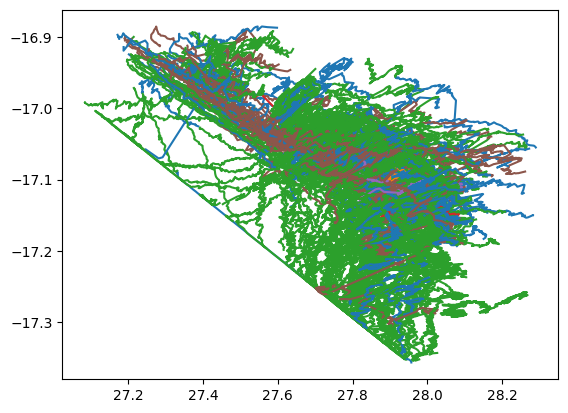

In [40]:
XTrain = XTrain.reshape(-1, traj_len, 2)
for i in range(XTrain.shape[0]):
    plt.plot(XTrain[i, :, 0], XTrain[i, :, 1], c=sns.color_palette()[y_pred[i]])

In [38]:
# silhouette_avg = silhouette_score(X_train.reshape(X_train.shape[0], -1), y_pred)
silhouette_avg = silhouette_score(XDIFF, y_pred)

# Print the silhouette score
print("For covariance_type tied The average silhouette score is :", silhouette_avg)  ## got better for n=6,9

For covariance_type tied The average silhouette score is : 0.09554258786912537


In [35]:
gmm = mixture.GaussianMixture(
        n_components=6,
        covariance_type="diag",
        random_state=42,
    )

gmm.fit(XDIFF)

y_pred = gmm.fit_predict(XDIFF)
# silhouette_avg = silhouette_score(X_train.reshape(X_train.shape[0], -1), y_pred)
silhouette_avg = silhouette_score(XDIFF, y_pred)

# Print the silhouette score
print("For covariance_type diag The average silhouette score is :", silhouette_avg)  ## got better for n=6,9

For covariance_type diag The average silhouette score is : 0.08252410813495402


In [21]:
gmm = mixture.GaussianMixture(
        n_components=6,
        covariance_type="spherical",
        random_state=42,
    
    )

gmm.fit(XDIFF)

y_pred = gmm.fit_predict(XDIFF)
# silhouette_avg = silhouette_score(X_train.reshape(X_train.shape[0], -1), y_pred)
silhouette_avg = silhouette_score(XDIFF, y_pred)

# Print the silhouette score
print("For covariance_type spherical The average silhouette score is :", silhouette_avg)  ## got better for n=6,9

For covariance_type diag The average silhouette score is : -0.15174084175645486


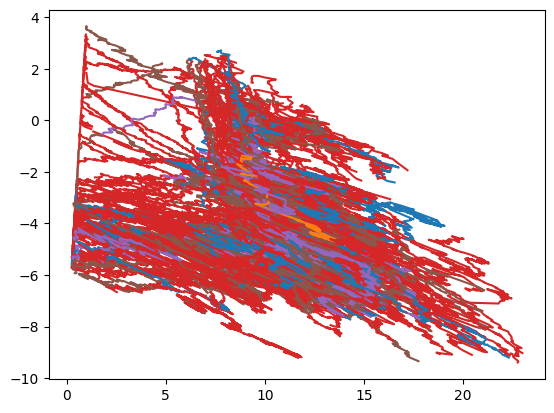

In [14]:
XTrain = XTrain.reshape(-1, traj_len, 2)
for i in range(XTrain.shape[0]):
    plt.plot(XTrain[i, :, 0], XTrain[i, :, 1], c=sns.color_palette()[y_pred[i]])

In [16]:
# Get the score for each sample
score = gmm.score_samples(XDIFF)
score

array([ 159.58768403,  303.89144872,  621.35272298,  326.68341235,
        324.92340762,  278.44026832,  306.06230183,  341.81329706,
        347.28933833,  195.5210168 ,  430.20987638,  430.44203059,
        621.4027658 ,  430.51604838,  430.18078358,  621.33837265,
        430.40683956,  344.00236943,  235.692763  ,  350.82629026,
        331.39653513,  345.80882277,  324.14557172,  430.00627269,
        430.15325517,  430.03221601,  302.105847  ,  321.93264359,
        311.46014614,  320.30685469,  338.14551112,  348.97497881,
        278.6962687 ,  321.45850845,  194.40640357,  322.35025285,
        338.23489093,  330.2376761 ,  621.33592347,  290.44469711,
        362.1349247 ,  356.14283612,  362.32761515,  365.41254744,
        362.28973363,  338.44422727,  277.23710632,  289.77492394,
        363.68780794,  310.21979062,  281.55728784,  360.53282843,
        363.26915373,  325.73351648,  430.41155385,  341.69557504,
        328.47179608,  330.79177337,  331.65669575,  308.86971

In [17]:
# Save score as a column
# gt['score'] = score
# Get the score threshold for anomaly
pct_threshold = np.percentile(score, 4)
print(f'The threshold of the score is {pct_threshold:.2f}')

The threshold of the score is 208.08


For n_clusters = 5, the average silhouette_score is : 0.12011169412149358


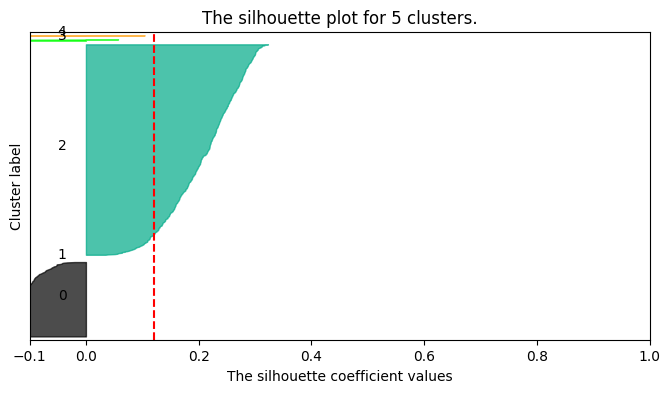

For n_clusters = 6, the average silhouette_score is : 0.07064410642684794


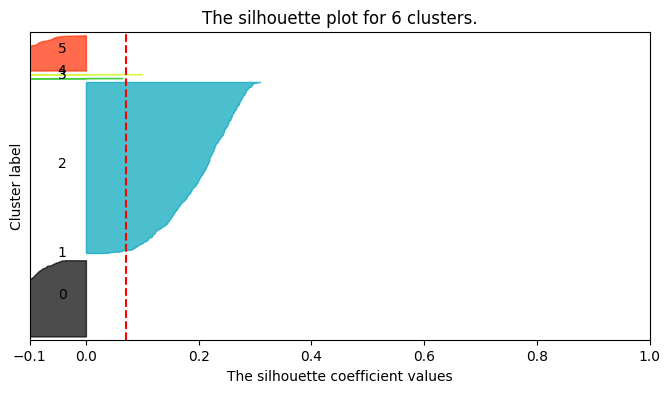

For n_clusters = 7, the average silhouette_score is : 0.06054427746683257


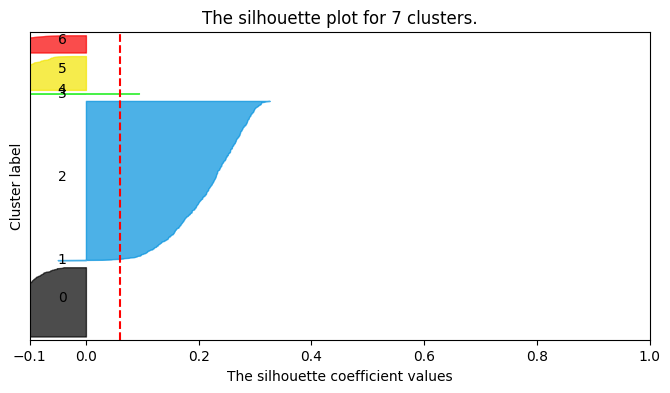

In [41]:
np.random.seed(20211231)

# Silhouette analysis for 2, 3, and 4 clusters
cluster_range = [5, 6, 7]

for n_clusters in cluster_range:
    # Create KMeans instance

    gmm = mixture.GaussianMixture(
        n_components=n_clusters,
        covariance_type="full",
        random_state=42,
    )

    gmm.fit(XDIFF)

    # Fit the model
    cluster_labels = gmm.predict(XDIFF)

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(XDIFF, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

    # Calculate silhouette values for each data point
    sample_silhouette_values = silhouette_samples(XDIFF, cluster_labels)

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(XDIFF) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Fill the silhouette plot
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"The silhouette plot for {n_clusters} clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()